In [2]:
# Common Python libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# For reading in images and image manipulation
import cv2

# For label encoding the target variable
from sklearn.preprocessing import LabelEncoder

# For tensor based operations
from tensorflow.keras.utils import to_categorical, normalize

# For Machine Learning
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# For face detection
#!pip install mtcnn
from mtcnn.mtcnn import MTCNN

# Loading the data

In [3]:
#train = pd.read_csv('/kaggle/input/face-mask-detection-dataset/train.csv')

images=os.path.join("/kaggle/input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/images")
annotations=os.path.join("/kaggle/input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/annotations")
train=pd.read_csv(os.path.join("/kaggle/input/face-mask-detection-dataset/train.csv"))
submission=pd.read_csv(os.path.join("/kaggle/input/face-mask-detection-dataset/submission.csv"))

# Exploring the train dataset

In [4]:
train.head()
#name: Image filename
#x1, x2, y1, y2: Bounding box coordinates
#classname: Bounding box label

,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask


In [5]:
print(f"Total number of rows:{len(train)}")

Total number of rows:15412


In [6]:
len(train["name"].unique()) # Total number of unique images

4326

In [7]:
train["classname"].unique()

array(['face_with_mask', 'mask_colorful', 'face_no_mask',
       'face_with_mask_incorrect', 'mask_surgical', 'face_other_covering',
       'scarf_bandana', 'eyeglasses', 'helmet', 'face_shield',
       'sunglasses', 'hood', 'hat', 'goggles', 'hair_net', 'hijab_niqab',
       'other', 'gas_mask', 'balaclava_ski_mask', 'turban'], dtype=object)

In [8]:
len(train["classname"].unique())

20

/tmp/ipykernel_36/1691043264.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, y_axis_val[i], y_axis_val[i], ha = 'center', fontsize = '17')


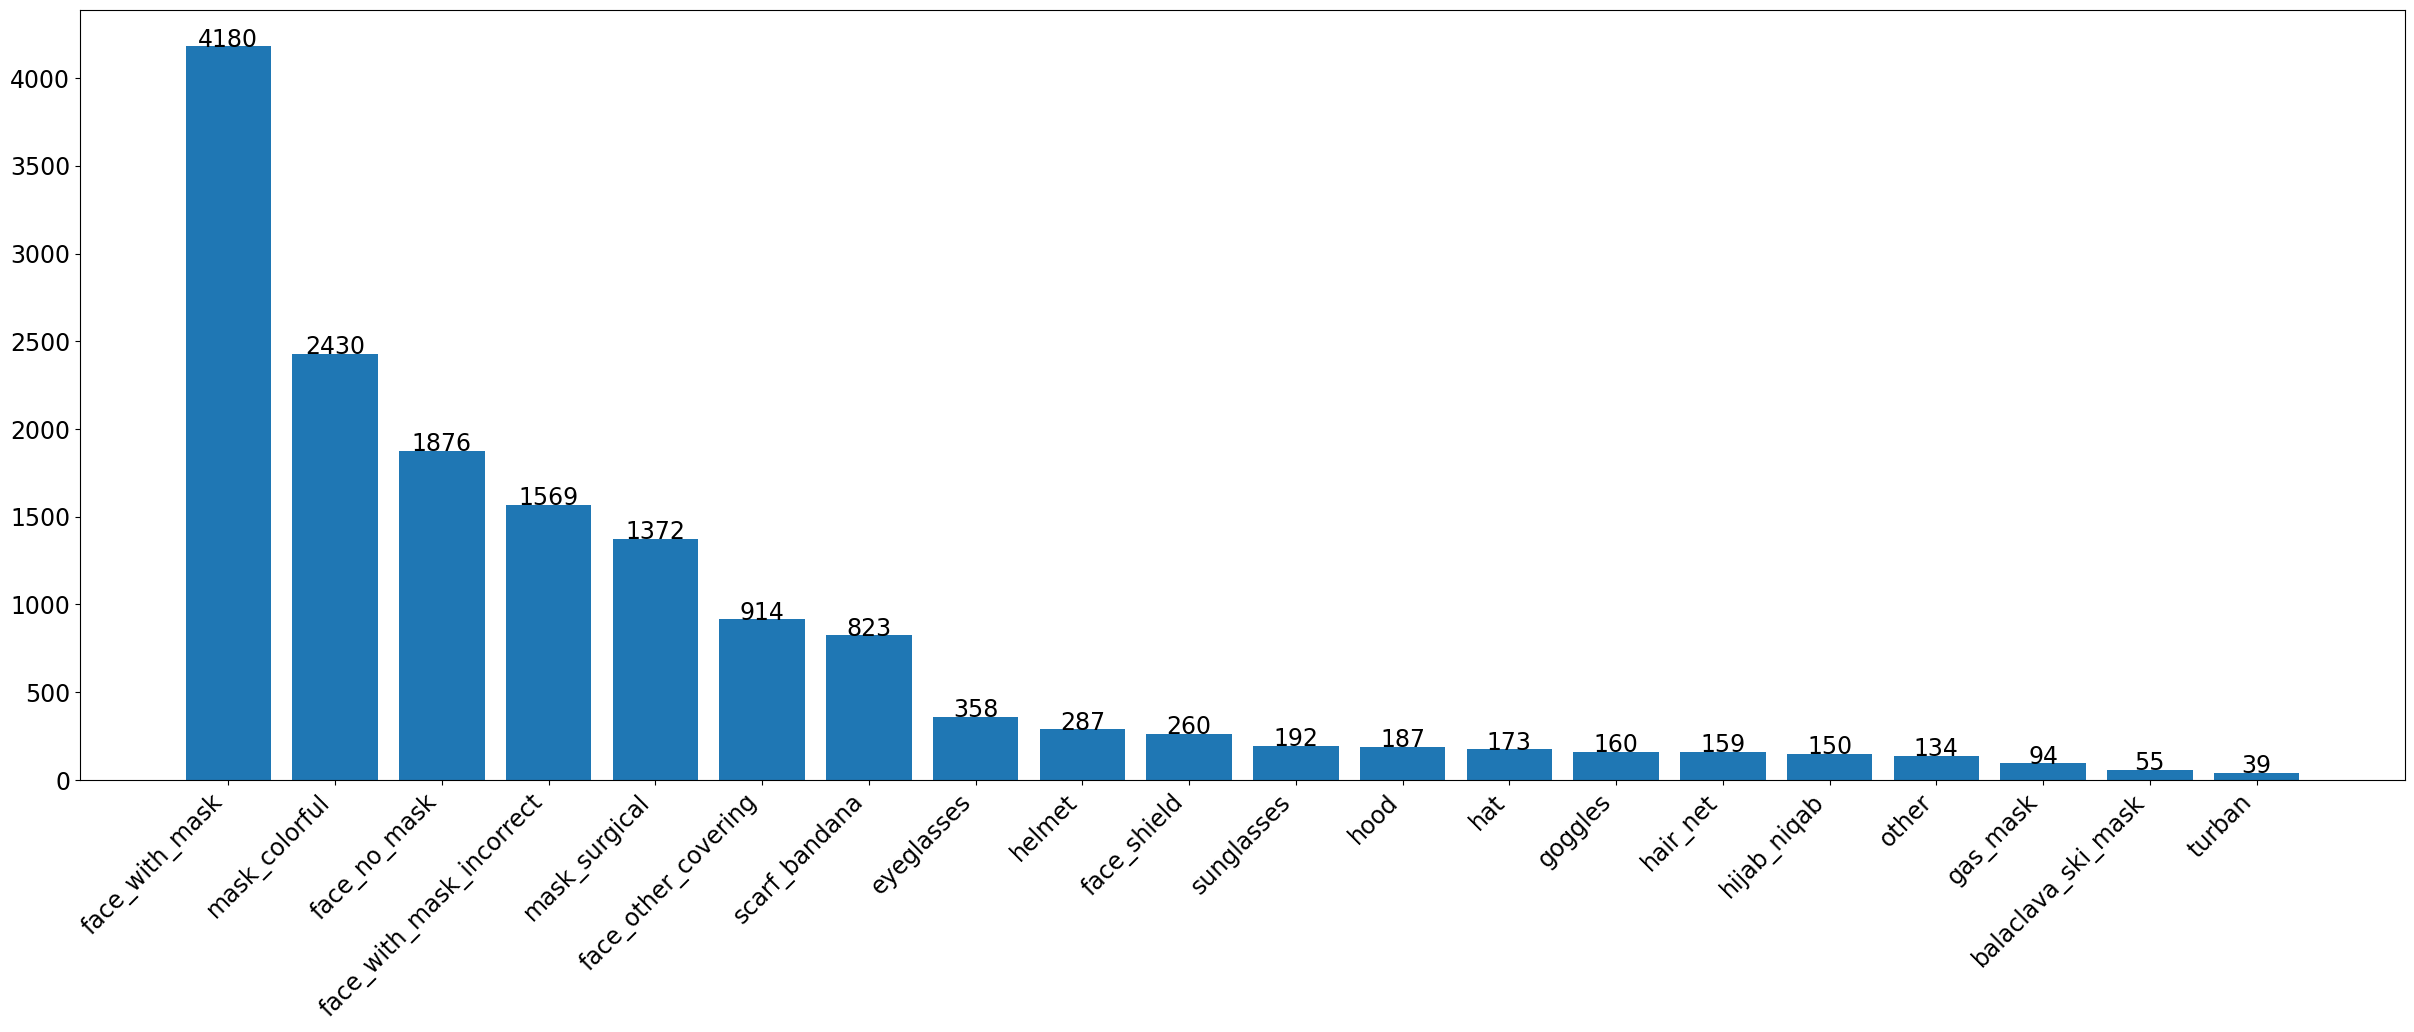

In [9]:
x_axis_val = train["classname"].unique()
y_axis_val = train.classname.value_counts()

# function to add value labels
def addlabels(x_axis_val, y_axis_val):
    for i in range(len(x_axis_val)):
        plt.text(i, y_axis_val[i], y_axis_val[i], ha = 'center', fontsize = '17')


        
# Plotting a bar plot
plt.figure(figsize=(30,10))
y_pos = np.arange(len(x_axis_val))
plt.yticks(fontsize ='17')
plt.xticks(y_pos, x_axis_val, rotation=45, fontsize='17', horizontalalignment='right')
plt.bar(x_axis_val, y_axis_val)
addlabels(x_axis_val, y_axis_val)


# Submission Data

In [10]:
print(len(submission))
submission.head()

8142


,name,x1,x2,y1,y2,classname
0,1800.jpg,NaN,NaN,NaN,NaN,NaN
1,1800.jpg,NaN,NaN,NaN,NaN,NaN
2,1800.jpg,NaN,NaN,NaN,NaN,NaN
3,1799.jpg,NaN,NaN,NaN,NaN,NaN
4,1799.jpg,NaN,NaN,NaN,NaN,NaN


# Looking at Images

In [11]:
print(f'We have {len(os.listdir(images))} images.')
print(f"Image file path: {images}")

We have 6024 images.
Image file path: /kaggle/input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/images


In [12]:
# Now setting the path to fetch the images
#images=os.path.join("/kaggle/input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/images")
images_filename = os.listdir(images) 
print(images_filename[:5])

['0664.jpg', '4353.png', '6234.jpg', '1269.jpg', '6241.jpg']


### Focusing on with mask and no mask

In [13]:
a=os.listdir(images)
b=os.listdir(annotations)
a.sort()
b.sort()

In [14]:
train_images=a[1698:]
test_images=a[:1698]

In [15]:
options=['face_with_mask','face_no_mask']
train= train[train['classname'].isin(options)]
train.sort_values('name',axis=0,inplace=True)

In [16]:
# We won't be using all the images for training but the ones present in the train['name'] column
train.head()

,name,x1,x2,y1,y2,classname
13381,1801.jpg,451,186,895,697,face_no_mask
3463,1802.jpg,110,71,273,272,face_with_mask
14835,1803.jpg,126,75,303,333,face_with_mask
5867,1804.jpg,112,113,262,307,face_with_mask
6194,1805.jpg,728,180,853,336,face_with_mask


In [17]:
# getting the training image file path
sample_image_name = train.iloc[0]['name']
sample_image_filepath = os.path.join(images, sample_image_name)
print(sample_image_filepath)

/kaggle/input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/images/1801.jpg


In [18]:
# Reading the image as an array
img = plt.imread(sample_image_filepath)
img

array([[[153, 147, 149],
        [153, 147, 149],
        [152, 146, 148],
        ...,
        [159, 155, 156],
        [161, 155, 157],
        [160, 154, 156]],

       [[152, 146, 148],
        [152, 146, 148],
        [152, 146, 148],
        ...,
        [160, 156, 157],
        [162, 156, 158],
        [161, 155, 157]],

       [[152, 146, 148],
        [152, 146, 148],
        [152, 146, 148],
        ...,
        [160, 156, 157],
        [161, 155, 157],
        [161, 155, 157]],

       ...,

       [[ 71,  67,  68],
        [ 71,  67,  68],
        [ 71,  67,  68],
        ...,
        [129, 119, 127],
        [128, 122, 126],
        [129, 123, 127]],

       [[ 71,  67,  68],
        [ 71,  67,  68],
        [ 71,  67,  68],
        ...,
        [129, 119, 127],
        [127, 121, 125],
        [128, 122, 126]],

       [[ 71,  67,  68],
        [ 70,  66,  67],
        [ 72,  68,  69],
        ...,
        [128, 121, 128],
        [131, 121, 129],
        [130, 120, 128]]

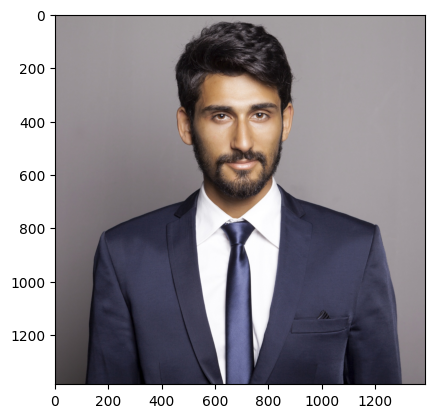

In [19]:
# Creating the figure and a sub-plot axis
fig, ax = plt.subplots()
ax.imshow(img)

In [20]:
# Successfully loaded the image as a numpy array. Lets now plot the pounding boxes too

# Select the rows with same name as in the name column of train dataset
# and then get the edges of the bounding box
df = train[train["name"] == sample_image_name]

bboxes = df[["x1","x2","y1","y2"]].values.tolist()
print(bboxes)
# each sublist is a bounding box

[[451, 186, 895, 697]]


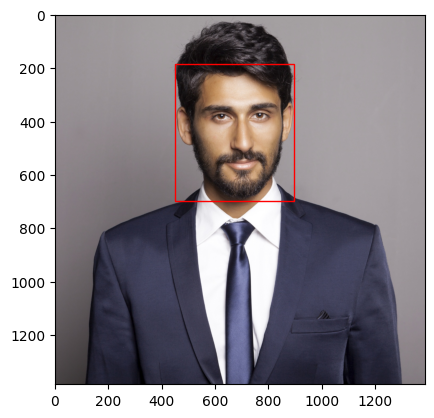

In [21]:
# Now using Rectangle patch from matplotlib.patches to plot bboxes
fig, ax = plt.subplots()

ax.imshow(img)

#plotting the bounding boxes
for box in bboxes:
    x1, x2, y1, y2 = box
    
    #x and y  coordinates
    # starting coordinate (x,y) as xy
    xy =(x1, x2)
    # width
    width = y1 -x1
    # height
    height = y2 -x2
    
    rect = patches.Rectangle(xy, width, height, linewidth =1, edgecolor ="r", facecolor ="none")
    ax.add_patch(rect)

plt.show()


# Creating the training dataset

The resolution is too high, so we'll be converting the image to 
* Greayscale
* Cropout the bounding box part
* resizing it 50 x 50


In [22]:
img_size = 50
data =[]

# Iterating through each row of the dataset
for index, row in train.iterrows():
    #single row
    name, x1, x2, y1, y2, classname = row.values
    # full file path
    full_filepath = os.path.join(images, name)
    # converting it to grey scale
    img_array = cv2.imread(full_filepath, cv2.IMREAD_GRAYSCALE)
       
    # Croppingout the portion covered by the bounding box
    crop_image = img_array[x2:y2, x1:y1]
    
    # Resizing the image
    new_img_array = cv2.resize(crop_image, (img_size, img_size))
    
    # Appending the arrays into a data variable along with bounding box
    data.append([new_img_array, classname])
    

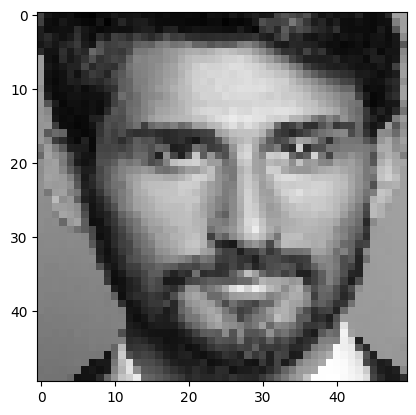

In [23]:
# Plotting one of the images after pre-processing
plt.imshow(data[0][0], cmap="gray")

# Seperating the independet variable and the dependent variable

In [24]:
# Initializing an empty list for features (independent variables)
x = []
# Initializing an empty list for labels (dependent variable)
y = []
for features, labels in data:
    x.append(features)
    y.append(labels)

In [25]:
x[0].shape

(50, 50)

In [26]:
# Reshaping the feature array (Number of images, IMG_SIZE, IMG_SIZE, Color depth)
x = np.array(x).reshape(-1, 50, 50, 1) # -1 == all images
x.shape

(5749, 50, 50, 1)

In [27]:
x[0].min(), x[0].max()

(4, 253)

In [28]:
# Normalizing
x = normalize(x, axis=1)

In [29]:
x[0].min(), x[0].max()

(0.006336624000624299, 0.3133853673620512)

In [30]:
# Label encoding y
lbl = LabelEncoder()
y = lbl.fit_transform(y)
# Converting it into a categorical variable
y = to_categorical(y)


# Training an Image Classification Model (CNN)

Architecture:
* Input Image
* 2D Convolutiion Layer
* MaxPooling Layer
* 2D Convolutiion Layer
* MaxPooling Layer --> Flatten
* Dense Layer--> Dropout
* Dense Layer --> Output

Binary Output


In [31]:
print(x.shape)

(5749, 50, 50, 1)


In [32]:
input_image_shape = x.shape[1:]
input_image_shape

(50, 50, 1)

Creating a sequential Keras model to add layers

In [33]:
model = Sequential() #Initializing a sequential keras model

Now creating a 2D convolution layer with:
* 100 different filters
* a filter shape 3 x 3
* a bias for each filter
* input image shape 50 x 50 x 1
* activation function as ReLU
* stride of 2
* valid padding (No padding)


In [34]:
#Adding a 2D Convolution layer
model.add(Conv2D(filters=100,
                kernel_size=(3,3),
                use_bias=True,
                input_shape= input_image_shape,
                activation='relu',
                strides =2))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Number of parameters = ( filter_size1 x Filter_size2 + bias) x Number of filters

Thus we have 1000 parameters.

Output Shape = [(input_shape_h + (2* padding) - filter_size)/ stride] +1

Thus output shape of 2D Convolution layer = 24 x 24 x 100



In [35]:
# Adding a max_pooling layer
model.add(MaxPooling2D(pool_size=(2,2)))
# The output shape of this layer would be (24/2) x (24/2) x 100

In [36]:
# Adding a 2D Convolution layer-- Output shape 10 x 10 x 64
model.add(Conv2D(filters=64,
                kernel_size=(3,3),
                use_bias= True,
                activation='relu'))
# Adding a maxpooling layer --> Output Shape  5 x 5 x 64
model.add(MaxPooling2D(pool_size=(2,2)))

In [37]:
# Adding a Flatten layer --> Output Shape = 5x5x64 = 1600
model.add(Flatten())

In [38]:
# Adding a dense layer --> Output shape = 50
model.add(Dense(50,activation='relu'))

Number of parameters here is (Number of neurons* shape of input array) + Number of bias
= (50 * 1600) * 50 = 80050

Adding a Dropout of 0.2 and a final Dense layer with the softmax activation function

In [39]:
model.add(Dropout(0.2))

model.add(Dense(2, activation='softmax'))

In [40]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 24, 24, 100)    │         1,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 100)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 10, 10, 64)     │        57,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │        80,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,816 (542.25 KB)

 Trainable params: 138,816 (542.25 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
#Initializing an adam optimizer
opt = Adam(learning_rate=1e-3,decay=1e-5)

#Configure the model for training
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Training the model
model.fit(x,y, epochs=30, batch_size=5)

/opt/conda/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Epoch 1/30


I0000 00:00:1726919547.998172     119 service.cc:145] XLA service 0x79ce60003eb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726919547.998224     119 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1726919547.998228     119 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  91/1150 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7094 - loss: 0.6274

I0000 00:00:1726919553.077244     119 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1150/1150 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.7298 - loss: 0.5815
Epoch 2/30
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7588 - loss: 0.4876
Epoch 3/30
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8019 - loss: 0.4342
Epoch 4/30
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8145 - loss: 0.4010
Epoch 5/30
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8311 - loss: 0.3699
Epoch 6/30
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8546 - loss: 0.3278
Epoch 7/30
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8687 - loss: 0.3026
Epoch 8/30
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8810 - loss: 0.2808
Epoch 9/30
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8919 - loss: 0.2541
Epoch 10/30
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8894 - loss: 0.2485
Epoch 11/30
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8985 - loss: 0.2356
Epoch 12/30
1150/1150 ━━━━━━━━━━━━━━━━━━

# Making Predictions on the out of training sample

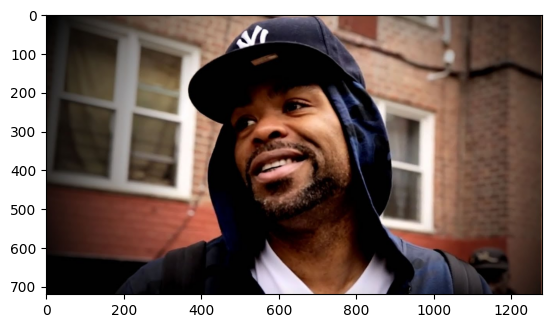

In [42]:
# Image file path for sample image
test_image_file_path = os.path.join(images,test_images[0])

# Loading in the image
img = plt.imread(test_image_file_path)

# Showing the image
plt.imshow(img)

In [50]:
# Initializing the detector
detector = MTCNN()

# Detecting the faces in the image
faces = detector.detect_faces(img)

print(faces)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
[{'box': [441, 108, 342, 417], 'confidence': 0.9999905824661255, 'keypoints': {'left_eye': (502, 270), 'right_eye': (642, 228), 'nose': (559, 296), 'mouth_left': (534, 412), 'mouth_right': (670, 373)}}]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


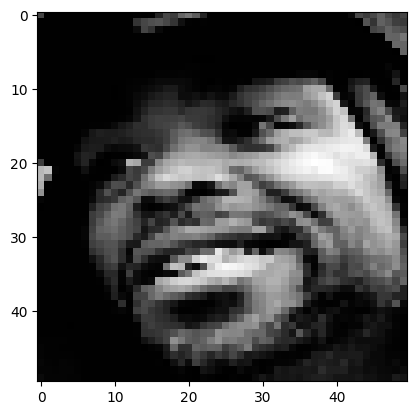

In [44]:
# Reading in the image as a grayscale image
img_array = cv2.imread(test_image_file_path, cv2.IMREAD_GRAYSCALE)

# Initializing the detector
detector = MTCNN()

# Detecting the faces in the image
faces = detector.detect_faces(img)

# Getting the values for bounding box
x1, x2, width, height = faces[0]["box"]

# Selecting the portion covered by the bounding box
crop_image = img_array[x2 : x2 + height, x1 : x1 + width]

# Resizing the image
new_img_array = cv2.resize(crop_image, (img_size, img_size))

# Plotting the image
plt.imshow(new_img_array, cmap="gray")

In [45]:
# Reshaping the image
x = new_img_array.reshape(-1, 50, 50, 1)

# Normalizing
x = normalize(x, axis=1)

In [53]:
prediction = model.predict(x)
print(prediction)
# [1,0]--> Face with no mask
# [0,1]--> Face with mask

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[[0.00733411 0.9926658 ]]


In [54]:
# Returns the index of the maximum value
np.argmax(prediction)
# 0--> Face with no mask
# 1--> Face with  mask

1